# 05b. Random labels, but with a good guess about N_classes

And the model is explicitly MORE (not LESS) expressive as in the 5a case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
class Const:
    """All constants collected together."""
    img_size = 28
    nclasses = 10
    benchmark_ind = [21, 276, 1397, 1409, 257, 537, 83, 96, 94, 247] # ths one grants 70% accuracy
    
C = Const()

In [3]:
(xtrain,ytrain), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

def scale_mnist(x):
    x  = x.astype('float32')/255
    x = np.expand_dims(x,3) # Weird extra axis for channels, to make keras work
    return x
    
xtrain = scale_mnist(xtrain)
xtest  = scale_mnist(xtest)

ytrain = tf.keras.utils.to_categorical(ytrain, C.nclasses)
ytest  = tf.keras.utils.to_categorical(ytest, C.nclasses)

In [4]:
# Collect limited datasets

def find_data(ytrain, nrows):
    hist = [0]*10
    indices = np.zeros((nrows, 10), dtype=int)
    i = 0
    while min(hist) < nrows:
        label = np.argmax(ytrain[i])
        if hist[label]<nrows:
            indices[hist[label], label] = i
            hist[label] += 1
        i += 1
    return indices
    
indices = find_data(ytrain, 20)
print(indices)

[[  1   3   5   7   2   0  13  15  17   4]
 [ 21   6  16  10   9  11  18  29  31  19]
 [ 34   8  25  12  20  35  32  38  41  22]
 [ 37  14  28  27  26  47  36  42  46  33]
 [ 51  23  76  30  53  65  39  52  55  43]
 [ 56  24  82  44  58 100  62  71  85  45]
 [ 63  40 109  49  60 132  66  79  94  48]
 [ 68  59 117  50  61 138  73  84  97  54]
 [ 69  67 120  74  64 145  83  91 125  57]
 [ 75  70 122  86  89 173  90  96 137  80]
 [ 81  72 143  98  92 175  93 101 144  87]
 [ 88  77 159 107 115 182 106 103 146 110]
 [ 95  78 161 111 127 191 126 123 160 116]
 [108  99 171 130 131 219 129 140 188 133]
 [114 102 178 135 139 236 147 141 197 153]
 [118 104 180 136 142 239 151 148 202 154]
 [119 105 187 149 150 244 155 158 225 162]
 [121 112 189 157 163 259 165 168 240 167]
 [156 113 190 179 164 266 186 185 245 170]
 [169 124 199 181 166 273 204 193 265 172]]


In [5]:
def _compile_model(model):
    """Helper function, just to not write this out every time."""
    model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])    
    return model

def build_model():
    """Build a naive model, then compile."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(C.img_size, C.img_size, 1)), # Universal input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(C.nclasses, activation='softmax')
    ])
    return _compile_model(model)

def reset_last_layer(model):
    """Reset last layer (actually copy all except the last layer)."""
    model2 = tf.keras.Sequential()
    for layer in model.layers[:-1]: # Copy from input model
        model2.add(layer)
    model2.add(tf.keras.layers.Dense(C.nclasses, activation='softmax')) # Last layer
    for layer in model2.layers[:-1]:
        layer.trainable = False
    return _compile_model(model2)

model = build_model()
#model.summary()

In [6]:
class PrintDot(tf.keras.callbacks.Callback):
    """Helper function to report running loss during training."""
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print(f" {logs['loss']:.3f}".replace('0.','.'), end='')

In [7]:
def train_model(model, x, y, epochs=40):
    hist = model.fit(x, y,
                      batch_size=1024,
                      epochs=40,
                      verbose=0,
                      validation_data=(xtest, ytest)) # Note that it's not validation, but rather test data

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    score = model.evaluate(xtest, ytest, verbose=0)
    return score[1]

## Pre-training (tran full network on partial data)

Accuracy: 
0.4471
0.2668
0.4066
0.4227
0.3263
0.3621
0.4316
0.396
0.4858
0.3964
0.2338
0.379
0.4517
0.2273
0.3573
0.3998
0.2909
0.3344
0.3115
0.3508


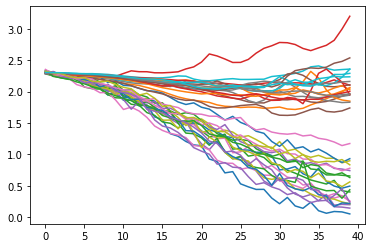

In [8]:
# No pre-training: just overfit a naive network with partial data:

print('Accuracy: ')
for i in range(indices.shape[0]):
    model = build_model()
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]])
    print(acc)

Accuracy: 
0.1135
0.3344
0.1135
0.1135
0.3374
0.3017
0.1135
0.1135
0.1135
0.1135
0.2432
0.4283
0.3388
0.1135
0.1135
0.1369
0.2497
0.1135
0.1135
0.377


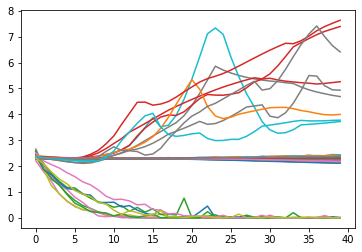

In [9]:
# Pretrain on random labels, then train again on a limited sample:
print('Accuracy: ')
for i in range(indices.shape[0]):
    randints = np.random.choice(range(len(ytrain)), size=len(ytrain), replace=False)
    model = build_model()    
    train_model(model, xtrain, ytrain[randints], epochs=300)
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

Accuracy: 
0.9858
0.9824
0.9617
0.9672
0.9586
0.9747
0.9723
0.952
0.9506
0.9376
0.9423
0.9516
0.9756
0.9744
0.9672
0.9668
0.9657
0.9724
0.9599
0.9746


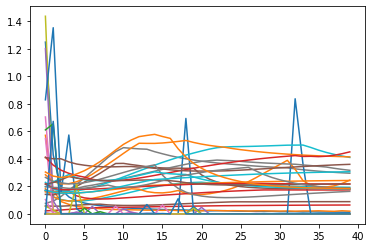

In [10]:
# Train on a full dataset, then rather stupidly train again on a limited sample:
print('Accuracy: ')
model = build_model()   
train_model(model, xtrain, ytrain, epochs=300)
for i in range(indices.shape[0]):
    model2 = tf.keras.Sequential()
    for layer in model.layers: # Copy all layers
        model2.add(layer)
    model2 = _compile_model(model2)
    acc = train_model(model2, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

## Embeddings (only train last layer)

Accuracy: 
0.1365
0.1763
0.1023
0.0649
0.1397
0.0897
0.0918
0.0931
0.0539
0.106
0.1054
0.1088
0.1126
0.1042
0.1034
0.1091
0.0694
0.115
0.1272
0.119


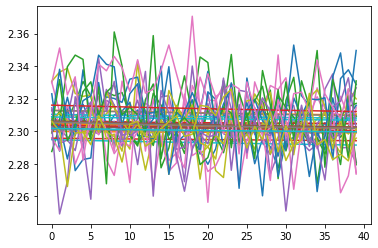

In [11]:
# Randomize all layers, but only train last layer (aka no pre-training, aka random embedding)
print('Accuracy: ')
for i in range(indices.shape[0]):
    model = build_model()
    model = reset_last_layer(model)
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

Accuracy: 
0.0982
0.0974
0.0974
0.0958
0.0925
0.0657
0.1042
0.101
0.0974
0.0963
0.1032
0.0958
0.1009
0.1135
0.098
0.0863
0.0892
0.0892
0.1028
0.1009


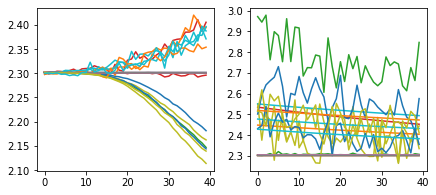

In [12]:
# Embedding on random labels:
print('Accuracy: ')
plt.figure(figsize=(7,3))
ax = [plt.subplot(1,2,i) for i in [1,2]]
for i in range(indices.shape[0]):
    randints = np.random.choice(range(len(ytrain)), size=len(ytrain), replace=False)
    model = build_model()
    plt.sca(ax[0])
    train_model(model, xtrain, ytrain[randints], epochs=300)
    model = reset_last_layer(model)
    plt.sca(ax[1])
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)

Accuracy: 
0.1278
0.1095
0.1869
0.0127
0.2909
0.2506
0.0218
0.1199
0.2832
0.086
0.0701
0.1226
0.0983
0.002
0.0403
0.1918
0.129
0.1946
0.2648
0.0399


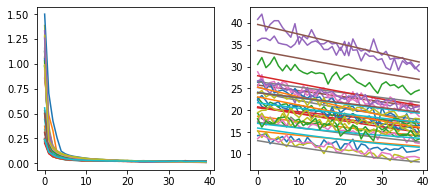

In [13]:
# Pre-training on full data, then retrain the last layer (aka presumably-ideal embedding)
print('Accuracy: ')
plt.figure(figsize=(7,3))
ax = [plt.subplot(1,2,i) for i in [1,2]]
for i in range(indices.shape[0]):
    model = build_model()
    plt.sca(ax[0])
    acc = train_model(model, xtrain, ytrain, epochs=300)
    model = reset_last_layer(model)
    plt.sca(ax[1])
    acc = train_model(model, xtrain[indices[i,:]], ytrain[indices[i,:]], epochs=300)
    print(acc)